In [1]:
import pandas as pd
import numpy as np
import os

import logging
logging.getLogger().setLevel(logging.INFO)

from alphabase.spectral_library.flat import SpecLibFlat
from alphabase.spectral_library.base import SpecLibBase
from alphabase.spectral_library.reader import LibraryReaderBase
from alphadia.extraction.utils import reannotate_fragments
from alphabase.psm_reader import psm_reader_provider

INFO:root:


In [2]:
import warnings 

def fragment_number(precursor_df, fragment_intensity_df) :
    if not set(['frag_start_idx', 'frag_stop_idx']).issubset(precursor_df.columns):
        warnings.warn('frag_start_idx and frag_stop_idx not in dataframe')
        return
    
    n_fragments = []
    
    for start, stop in zip(precursor_df['frag_start_idx'].values, precursor_df['frag_stop_idx'].values):
        n_fragments += [np.sum(fragment_intensity_df.iloc[start:stop].values > 0)]

    precursor_df['n_fragments'] = n_fragments

In [13]:
lib_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/21min_Evosep_HeLa_BR14_48fractions_diaPASEF_py_diAID_2.tsv'
#insilico_lib_location = '/Users/georgwallmann/Documents/data/libraries/2022_111_brunner_2022_1ng_all_29_human_trypsin_diann_decoy.hdf'


In [14]:
# create dense library from diann psm file
target_lib = LibraryReaderBase()
target_lib.import_file(lib_location)

#target_lib._fragment_mz_df = target_lib._fragment_mz_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]
#target_lib._fragment_intensity_df = target_lib._fragment_intensity_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]

#target_lib._precursor_df['elution_group_idx'] = np.arange(len(target_lib._precursor_df))

/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/reader.py:250: DtypeWarning: Columns (33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, sep=self.csv_sep)


,uniprot_ids,nAA,rt,proteins,mod_sites,raw_name,charge,precursor_mz,genes,sequence,mods,mobility,frag_start_idx,frag_stop_idx,rt_norm,ccs
0,A0A024RBG1,12,37.883335,NUD4B_HUMAN,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,2,730.896440,NUDT4B,LLGIFEQNQDRK,,1.041,0,11,0.251158,420.894147
1,A0A024RBG1,12,37.883335,NUD4B_HUMAN,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,3,487.600052,NUDT4B,LLGIFEQNQDRK,,0.777,11,22,0.255296,471.228582
2,A0A024RBG1,11,55.980396,NUD4B_HUMAN,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,2,666.848958,NUDT4B,LLGIFEQNQDR,,0.969,22,32,0.371505,392.136762
3,A0A087WSZ0,18,49.475310,KVD08_HUMAN,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,3,691.347175,IGKV1D-8,MSQGISSYLAWYQQKPGK,,0.921,32,49,0.328335,557.012501
4,A0A096LP01,16,8.595059,SIM26_HUMAN,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,2,844.410305,SMIM26,DGSASEVPSELSERPK,,1.068,49,64,0.058067,431.264870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235305,Q9Y6Y8,15,34.524582,S23IP_HUMAN,3;13,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,4,447.473638,SEC23IP,VGMEINHLHALFMSR,Oxidation@M;Oxidation@M,0.821,3084894,3084908,0.232662,662.744153
235306,Q9Y6Y8,15,34.524582,S23IP_HUMAN,3;13,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,3,596.295758,SEC23IP,VGMEINHLHALFMSR,Oxidation@M;Oxidation@M,0.884,3084908,3084922,0.228079,535.202532
235307,Q9Y6Y8,25,57.074530,S23IP_HUMAN,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,3,943.470250,SEC23IP,VIVQFQPSSVPDEWGTTQDGQTRPR,,1.026,3084922,3084946,0.389358,619.410177
235308,Q9Y6Y8,16,33.653854,S23IP_HUMAN,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,3,609.959751,SEC23IP,VVESPDFSKDEDYLGK,,0.842,3084946,3084961,0.200145,509.686355


In [16]:
target_lib._precursor_df['decoy'] = 0

In [17]:
target_lib._precursor_df['elution_group_idx'] = np.arange(len(target_lib._precursor_df))
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)

In [18]:
decoy_lib = SpecLibBase()
decoy_lib._precursor_df = target_lib.precursor_df.copy()
decoy_lib._fragment_mz_df = target_lib._fragment_mz_df.copy()
decoy_lib._fragment_intensity_df = target_lib._fragment_intensity_df.copy()

#decoy_lib.import_file(brunner_lib)
decoy_lib.decoy = 'diann'
decoy_lib.append_decoy_sequence()
decoy_lib.calc_precursor_mz()
decoy_lib.precursor_df = decoy_lib.precursor_df[decoy_lib.precursor_df['decoy'] == 1]

In [19]:
from peptdeep.pretrained_models import ModelManager
from alphabase.peptide.fragment import get_charged_frag_types

frag_types = get_charged_frag_types(
    ['b','y','b_modloss', 'y_modloss'], 
    2
)

model_mgr = ModelManager()

model_mgr.nce = 30
model_mgr.instrument = 'timsTOF'

In [20]:
res = model_mgr.predict_all(
    decoy_lib.precursor_df,
    predict_items=['ms2'],
    frag_types = frag_types,
)

decoy_lib._precursor_df = res['precursor_df']
decoy_lib._fragment_mz_df = res['fragment_mz_df']
decoy_lib._fragment_intensity_df = res['fragment_intensity_df']

2023-03-06 15:08:34> Using multiprocessing with 8 processes ...
2023-03-06 15:08:34> Predicting ms2 ...


100%|██████████| 46/46 [00:48<00:00,  1.06s/it]


In [22]:
decoy_lib._precursor_df[['frag_start_idx']] += len(target_lib._fragment_mz_df)
decoy_lib._precursor_df[['frag_stop_idx']] += len(target_lib._fragment_mz_df)

In [23]:
output_lib = SpecLibBase()

output_lib._precursor_df = pd.concat([target_lib._precursor_df, decoy_lib._precursor_df], join='inner')
output_lib._fragment_mz_df = pd.concat([target_lib._fragment_mz_df, decoy_lib._fragment_mz_df], join='inner')
output_lib._fragment_intensity_df = pd.concat([target_lib._fragment_intensity_df, decoy_lib._fragment_intensity_df], join='inner')

In [24]:
output_lib._precursor_df = output_lib._precursor_df.sort_values(by=['genes']).reset_index(drop=True)
output_lib._precursor_df['precursor_idx'] = np.arange(len(output_lib.precursor_df))

In [25]:
output_lib.precursor_df

,uniprot_ids,nAA,rt,proteins,mod_sites,raw_name,charge,precursor_mz,genes,sequence,mods,mobility,frag_start_idx,frag_stop_idx,rt_norm,ccs,decoy,elution_group_idx,n_fragments,precursor_idx
0,P01023,9,51.729183,A2MG_HUMAN,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,2,510.808042,A2M,ASVLNYLLK,,0.862,3353096,3353104,0.044876,349.938903,1,30714,7,0
1,P01023,9,51.729183,A2MG_HUMAN,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,2,509.800217,A2M,ATVLNYLPK,,0.862,404314,404322,0.044876,349.938903,0,30714,7,1
2,P01023,13,46.246643,A2MG_HUMAN,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,2,722.933448,A2M,MLSGFIPLKPTLK,,1.039,4250696,4250708,0.308031,420.207885,1,30718,11,2
3,P01023,13,46.246643,A2MG_HUMAN,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,3,482.291391,A2M,MLSGFIPLKPTLK,,0.843,4250708,4250720,0.308031,511.404444,1,30719,7,3
4,P01023,13,38.053470,A2MG_HUMAN,1,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,2,730.930906,A2M,MLSGFIPLKPTLK,Oxidation@M,1.034,4250720,4250732,0.253459,418.140536,1,30720,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465274,Q8IYH5,17,30.439524,ZZZ3_HUMAN,4,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,3,650.656120,ZZZ3,LQQMQAESGFVQHVGFK,Oxidation@M,0.947,1882746,1882762,0.209164,572.975573,0,143198,14,465274
465275,Q8IYH5,12,31.237576,ZZZ3_HUMAN,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,2,683.354074,ZZZ3,QNSIGSYVLQEK,,0.995,1882762,1882773,0.190451,402.558489,0,143199,5,465275
465276,Q8IYH5,15,-6.967744,ZZZ3_HUMAN,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,2,827.413182,ZZZ3,SIAHPEEISSNSQVR,,1.081,1882773,1882787,-0.046313,436.587466,0,143200,7,465276
465277,Q8IYH5,17,30.439524,ZZZ3_HUMAN,4,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,3,634.656120,ZZZ3,LNQMQAESGFVQHVGLK,Oxidation@M,0.947,5448394,5448410,0.209164,572.975573,1,143198,14,465277


In [26]:
for i, (start_idx, stop_idx, k_allowed) in enumerate(zip(output_lib.precursor_df['frag_start_idx'].values, output_lib.precursor_df['frag_stop_idx'].values,output_lib.precursor_df['n_fragments'].values)):
    intensies = output_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values
    flat_intensities = np.sort(intensies.flatten())[::-1]
    output_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values[intensies <= flat_intensities[k_allowed]] = 0


In [27]:
fragment_number(output_lib.precursor_df, output_lib._fragment_intensity_df)

<AxesSubplot:xlabel='n_fragments', ylabel='Count'>

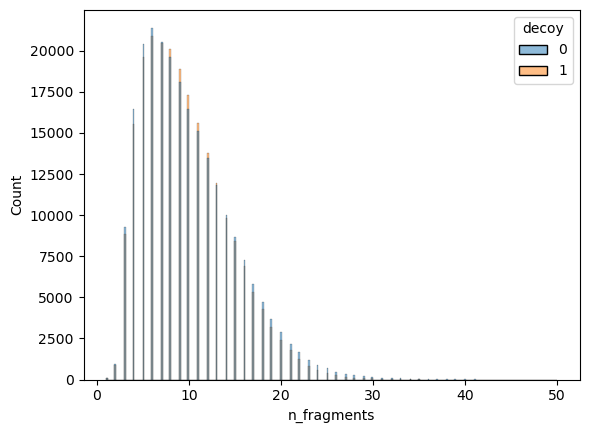

In [28]:
import seaborn as sns
sns.histplot(output_lib.precursor_df, x ='n_fragments', hue='decoy')

In [29]:
from tqdm import tqdm
from alphabase.peptide.precursor import get_mod_seq_formula
from alphabase.constants.isotope import IsotopeDistribution


def calc_isotope_dist(precursor_df, max_isotope = 6, min_intensity = 0.001):
    isotope_dist = IsotopeDistribution()

    col_names = ['i_{}'.format(i) for i in range(max_isotope)]
    precursor_df[col_names] = 0.

    for i in tqdm(range(len(precursor_df))):

        row = precursor_df.iloc[i]
        dist, mono = isotope_dist.calc_formula_distribution(
            get_mod_seq_formula(row['sequence'], row['mods'])
        )
        dist[dist < 0.001] = 0.
        dist = dist / dist.sum()
        precursor_df.loc[i, col_names] = dist[:max_isotope]

In [30]:
calc_isotope_dist(output_lib.precursor_df)

100%|██████████| 465279/465279 [02:55<00:00, 2651.07it/s]


In [31]:
output_lib._precursor_df.drop(columns=['rt'], inplace=True)

In [33]:
output_lib._precursor_df.columns

Index(['uniprot_ids', 'nAA', 'proteins', 'mod_sites', 'raw_name', 'charge',
       'precursor_mz', 'genes', 'sequence', 'mods', 'mobility',
       'frag_start_idx', 'frag_stop_idx', 'rt_norm', 'ccs', 'decoy',
       'elution_group_idx', 'n_fragments', 'precursor_idx', 'i_0', 'i_1',
       'i_2', 'i_3', 'i_4', 'i_5'],
      dtype='object')

In [35]:
output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/21min_Evosep_HeLa_BR14_48fractions_diaPASEF_py_diAID_2.hdf'
output_lib.save_hdf(output_location)

In [36]:
res = model_mgr.predict_all(
    output_lib.precursor_df,
    predict_items=['ms2'],
    frag_types = frag_types,
)

output_lib._precursor_df = res['precursor_df']
output_lib._fragment_mz_df = res['fragment_mz_df']
output_lib._fragment_intensity_df = res['fragment_intensity_df']

2023-03-06 15:20:05> Using multiprocessing with 8 processes ...
2023-03-06 15:20:05> Predicting ms2 ...


  0%|          | 0/46 [00:00<?, ?it/s]

In [24]:
output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/21min_Evosep_HeLa_BR14_48fractions_diaPASEF_py_diAID_2_predicted.hdf'
output_lib.save_hdf(output_location)

,charge,decoy,frag_start_idx,frag_stop_idx,mod_seq_charge_hash,mod_seq_hash,precursor_mz,rt_norm,sequence
0,2,0,0,10,-5902435420383966768,-5902435420383966770,612.347732,0.241146,PLLVEPEGLEK
1,2,1,830315,830325,3766648993549763556,3766648993549763554,598.332079,0.241146,PVLVEPEGLDK
2,2,1,830445,830455,-6493297862235435738,-6493297862235435740,631.361170,0.346738,FLVALLDDSLR
3,3,1,1375298,1375329,-5108992742693614900,-5108992742693614903,1188.616697,0.564155,NTPVFELLPCGIIQGEPGAQPQLITFHPSFQK
4,2,1,727414,727420,6291183742222227837,6291183742222227835,419.299656,0.367114,PLILLLR
...,...,...,...,...,...,...,...,...,...
104103,2,0,723635,723644,2980994722975182420,2980994722975182418,589.837000,0.505580,EFSVLTELLK
104104,2,1,785202,785211,-5129586941915768509,-5129586941915768511,565.836997,0.505580,ELSVLTELVK
104105,2,0,723644,723658,-127859424326117553,-127859424326117555,842.425429,0.129388,LISSTESELQQSYAK
104106,3,1,1088188,1088203,3274813486705130588,3274813486705130585,628.010892,0.515030,TVQFIQQLAHDLVQNK
